In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import pytorch_model_summary as pms 

from torch.utils.data import TensorDataset, DataLoader

from torchvision.transforms import v2
import torchvision

from pytorchtools import EarlyStopping

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")




Using cpu device


In [4]:
from torchvision.io import read_image

In [5]:
# %load solutions/CNN_exercise_64.py
train_dataset_64 = torchvision.datasets.ImageFolder('data/chest_xray_64/train', 
                                         loader = read_image,
                                         transform = v2.ToDtype(torch.float32),
                                         target_transform = lambda x : torch.Tensor([x])  )
valid_dataset_64 = torchvision.datasets.ImageFolder('data/chest_xray_64/test', 
                                         loader = read_image,
                                         transform = v2.ToDtype(torch.float32),
                                         target_transform = lambda x : torch.Tensor([x])   )
    
    
batch_size = 64
train_dataloader_64 = DataLoader( dataset= train_dataset_64 , shuffle=True , batch_size = batch_size )
valid_dataloader_64 = DataLoader( dataset= valid_dataset_64 , shuffle=True , batch_size = batch_size )

class CNN(nn.Module):
    def __init__(self, input_size = 224,
                       channel_numbers=1 , 
                       kernel_size= 16, 
                       stride = 4):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = channel_numbers , 
                      out_channels = 2, 
                      kernel_size = kernel_size, 
                      stride= stride ),
            nn.ReLU(True), # inplace ReLU
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels = 2, out_channels = 4, kernel_size=5, stride=1),
            nn.ReLU(True), 
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.flatten = nn.Flatten()
        
        ###
        O1 = int( 1 + ((input_size - (kernel_size-1)-1)/stride) ) 
        O2 = int(  O1 / 2  ) 
        O3 =  1 + ((O2 - (5-1)-1)/1) 
        O4 = int(  O3 / 2  ) 
        flatten_output_dim = O4**2*4
        ###
        
        self.classifier = nn.Sequential(
            nn.Linear(flatten_output_dim, 16),
            nn.Linear(16, 8), 
            nn.Linear(8, 1),
            nn.Sigmoid())

    def forward(self, x):

        out = self.conv(x)

        out = self.flatten(out)

        out = self.classifier(out)

        return out

In [6]:
model = CNN(input_size = 64,
            channel_numbers=1 , 
            kernel_size= 11, 
            stride = 2).to(device)

x,y = train_dataset_64[0]


print(pms.summary(model, x.reshape(1,1,64,64).to(device) , show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 1, 64, 64]             244             244
            ReLU-2      [1, 2, 27, 27]               0               0
       MaxPool2d-3      [1, 2, 27, 27]               0               0
          Conv2d-4      [1, 2, 13, 13]             204             204
            ReLU-5        [1, 4, 9, 9]               0               0
       MaxPool2d-6        [1, 4, 9, 9]               0               0
         Flatten-7        [1, 4, 4, 4]               0               0
          Linear-8             [1, 64]           1,040           1,040
          Linear-9             [1, 16]             136             136
         Linear-10              [1, 8]               9               9
        Sigmoid-11              [1, 1]               0               0
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
--------

In [13]:
## we also define this to easily get accuracy 
def get_model_accuracy(model, dataloader):
    Ys = np.array([] , dtype = 'float32' )
    Ps = np.array([], dtype = 'float32' )
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)

            Ys = np.concatenate([Ys, y.squeeze().cpu().numpy()])
            Ps = np.concatenate([Ps, (pred>0.5).squeeze().cpu().numpy()])

    return np.mean( Ys == Ps )

def train(dataloader, model, loss_fn, optimizer ,  echo = True , echo_batch = False):
    
    size = len(dataloader.dataset) # how many batches do we have
    model.train() #     Sets the module in training mode.
    
    for batch, (X,y) in enumerate(dataloader): # for each batch
        X = X.to(device) # send the data to the GPU or whatever device you use for training
        y = y.to(device) # send the data to the GPU or whatever device you use for training

        # Compute prediction error
        pred = model(X)              # prediction for the model -> forward pass
        loss = loss_fn(pred, y)      # loss function from these prediction        
        
        # Backpropagation
        loss.backward()              # backward propagation 
        #                            https://ml-cheatsheet.readthedocs.io/en/latest/backpropagation.html
        #                            https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
        
        optimizer.step()             
        optimizer.zero_grad()        # reset the gradients
                                     # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch

        if echo_batch:
            current =  (batch) * dataloader.batch_size +  len(X)
            print(f"Train loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    
    if echo:
        print(f"Train loss: {loss.item():>7f}")

    # return the last batch loss
    return loss.item()

def valid(dataloader, model, loss_fn, echo = True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() #     Sets the module in evaluation mode
    valid_loss = 0
    with torch.no_grad(): ## disables tracking of gradient: prevent accidental training + speeds up computation
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()  ## accumulating the loss function over the batches
            
    valid_loss /= num_batches

    if echo:
        print(f"Valid Error: {valid_loss:>8f}")
    ## return the average loss / batch
    return valid_loss


In [14]:
for batch, (X,y) in enumerate(train_dataloader_64): 
    print(batch , X.shape, y.shape)
    break

loss = nn.BCELoss()

with torch.no_grad():
    pred = model(X.to(device))
    print(pred.shape)
    print( 'avg loss:', loss( pred , y.to(device) ) )

0 torch.Size([64, 1, 64, 64]) torch.Size([64, 1])
torch.Size([64, 1])
avg loss: tensor(1.3081)


In [29]:
## preamble -> define the loss function, and the optimizer
model = CNN(input_size = 64,
            channel_numbers=1 , 
            kernel_size= 11, 
            stride = 1).to(device)

loss = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr = 10**-6 , momentum=0.99) 


## container to keep the scores across all epochs
train_scores = []
valid_scores = []


# overfitting can be an issue here. 
# we use the early stopping implemented in https://github.com/Bjarten/early-stopping-pytorch
# initialize the early_stopping object. 
# patience: How long to wait after last time validation loss improved.
early_stopping = EarlyStopping(patience=25, verbose=False)


## naive accuracy
print("naive performance")
print( "train accuracy:", get_model_accuracy(model, train_dataloader_64) )
print( "valid accuracy:", get_model_accuracy(model, valid_dataloader_64) )

naive performance
train accuracy: 0.25783639143730885
valid accuracy: 0.375


In [30]:
%%time
## lets do a single round, to learn how long it takes
train_scores.append( train(train_dataloader_64, 
                           model, 
                           loss, 
                           optimizer, 
                           echo = False , echo_batch = True ) )

valid_scores.append( valid(valid_dataloader_64, 
                           model, 
                           loss , 
                           echo = True) )

Train loss: 1.122689  [   64/ 5232]
Train loss: 1.084735  [  128/ 5232]
Train loss: 1.042425  [  192/ 5232]
Train loss: 0.980327  [  256/ 5232]
Train loss: 1.083397  [  320/ 5232]
Train loss: 1.020029  [  384/ 5232]
Train loss: 1.053464  [  448/ 5232]
Train loss: 1.059322  [  512/ 5232]
Train loss: 1.071939  [  576/ 5232]
Train loss: 0.998549  [  640/ 5232]
Train loss: 0.948152  [  704/ 5232]
Train loss: 0.955431  [  768/ 5232]
Train loss: 0.888703  [  832/ 5232]
Train loss: 0.933001  [  896/ 5232]
Train loss: 1.052324  [  960/ 5232]
Train loss: 0.979185  [ 1024/ 5232]
Train loss: 0.928400  [ 1088/ 5232]
Train loss: 0.891434  [ 1152/ 5232]
Train loss: 0.856013  [ 1216/ 5232]
Train loss: 0.870226  [ 1280/ 5232]
Train loss: 0.851729  [ 1344/ 5232]
Train loss: 0.826525  [ 1408/ 5232]
Train loss: 0.835374  [ 1472/ 5232]
Train loss: 0.776994  [ 1536/ 5232]
Train loss: 0.805981  [ 1600/ 5232]
Train loss: 0.751347  [ 1664/ 5232]
Train loss: 0.785304  [ 1728/ 5232]
Train loss: 0.748964  [ 1792

In [31]:
epoch = 100



for t in range(epoch):
    echo = t%5==0
    if echo:
        print('Epoch',len(train_scores)+1 )    

    train_scores.append( train(train_dataloader_64, 
                               model, 
                               loss, 
                               optimizer, 
                               echo = echo , echo_batch = False ) )

    valid_scores.append( valid(valid_dataloader_64, 
                               model, 
                               loss , 
                               echo = echo) )

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_scores[-1], model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        

Epoch 2
Train loss: 0.672842
Valid Error: 0.758120
Epoch 7
Train loss: 0.436014
Valid Error: 0.663907
Epoch 12
Train loss: 0.435045
Valid Error: 0.530270
Epoch 17
Train loss: 0.312175
Valid Error: 0.398608
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Epoch 22
Train loss: 0.232032
Valid Error: 0.388758
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
Epoch 27
Train loss: 0.138822
Valid Error: 0.413771
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
Epoch 32
Train loss: 0.124104
Valid Error: 0.411840
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25
EarlyStopping counter: 8 out of 25
EarlyStopping counter: 9 out of 25
EarlyStopping counter: 10 out of 25
Epoch 37
Train loss: 0.165429
Valid Error: 0.406737
EarlyStopping counter: 11 out of 25
EarlyStopping counter: 1

train accuracy: 0.9159021406727829
valid accuracy: 0.8493589743589743


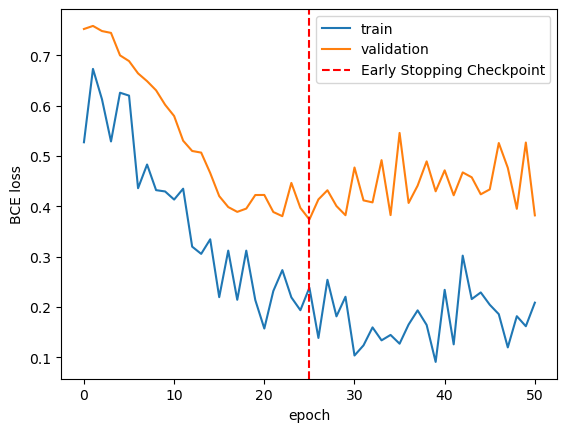

In [72]:
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))
plt.plot(train_scores , label = 'train')
plt.plot(valid_scores, label = 'validation')
plt.axvline(np.argmin(valid_scores), linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('BCE loss')
print( "train accuracy:", get_model_accuracy(model, train_dataloader_64) )
print( "valid accuracy:", get_model_accuracy(model, valid_dataloader_64) )

tensor([1, 0, 0, 1], dtype=torch.int32)

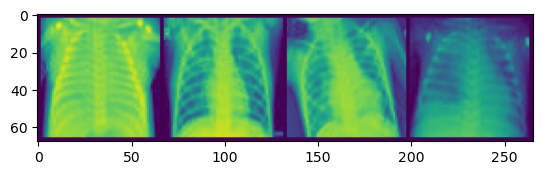

GroundTruth:  pneumonia	pneumonia	pneumonia	pneumonia
Predicted  :  pneumonia	pneumonia	pneumonia	pneumonia


In [103]:
def imshow(img):
    
    npimg = img.numpy()
    plt.imshow(npimg[0])
    plt.show()

images,labels = next( iter( train_dataloader_64 ) )

images = images[:4]
labels = labels[:4,0].int()

classes = ['normal   ',
           'pneumonia']
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', '\t'.join('%5s' % classes[ int( labels[j] ) ] for j in range(4)))


outputs = model(images.to(device))

predicted = outputs[:,0].detach().to('cpu').round().numpy().astype(int)

print('Predicted  : ', '\t'.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [104]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

In [93]:
model.eval()

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 2, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(2, 4, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=484, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

In [130]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              **kwargs
                                             )
    
    return tensor_attributions

In [131]:

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [132]:
model( input )

tensor([[0.8529]], grad_fn=<SigmoidBackward0>)

In [164]:

saliency = Saliency(model)
grads = saliency.attribute(input.to(device))
grads = np.transpose( grads.squeeze(0).cpu().detach().numpy() , (1,2,0)  )

In [165]:

ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input.to(device), 
                                          baselines=input.to(device) * 0, 
                                          return_convergence_delta=True)

attr_ig = np.transpose(attr_ig.squeeze(0).cpu().detach().numpy(), (1,2,0)  )
print('Approximation delta: ', abs(delta))


Approximation delta:  tensor([0.0016], dtype=torch.float64)


In [166]:
%%time
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input.to(device), baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1,2,0)  )


CPU times: user 10.5 s, sys: 532 ms, total: 11.1 s
Wall time: 2.77 s


In [167]:
dl = DeepLift(model)
attr_dl = attribute_image_features(dl, input.to(device), baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1,2,0)  )

/home/wandrille/Documents/trainingProjects/introduction_to_deepLearning/pytorch-practical-training/.pixi/envs/default/lib/python3.13/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Original Image
Predicted: pneumonia  Probability: 0.8529293537139893


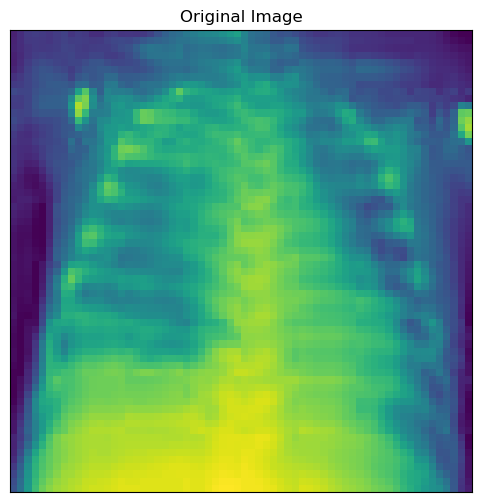

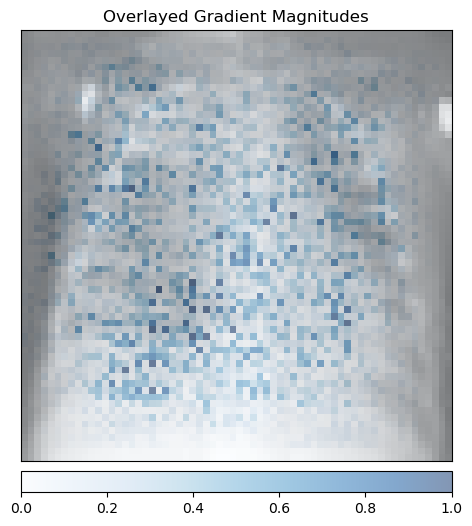

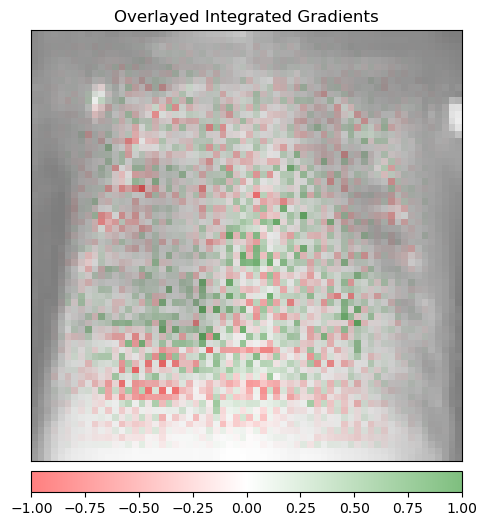

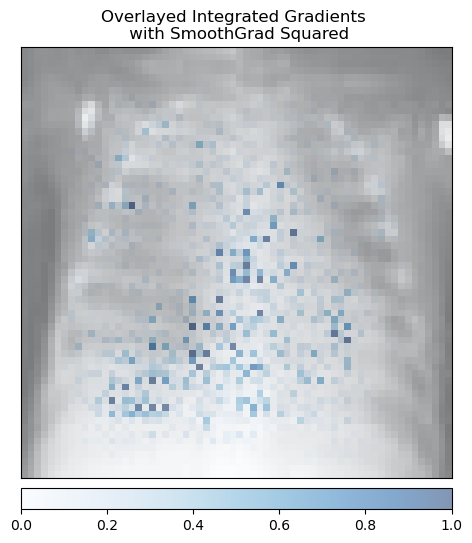

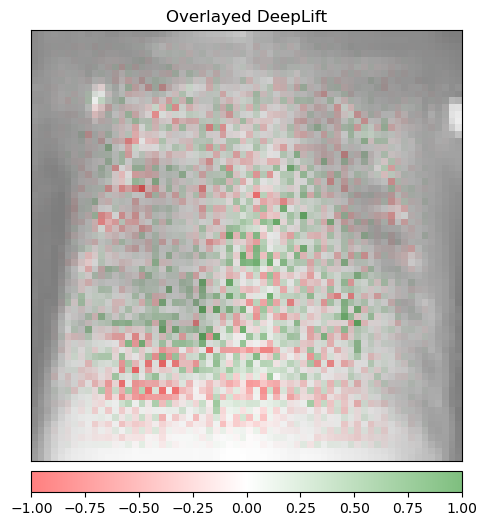

In [170]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', outputs[ind][0].item())

original_image = np.transpose( (images[ind].cpu().detach().numpy() / 2) + 0.5 , (1,2,0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")